In [3]:
%reload_ext autoreload
%autoreload 2

import os
import sys
from tqdm import tqdm

import numpy as np
import healpy as hp
from astropy.io import fits
from scipy.signal import convolve2d

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [4]:
sys.path.append("..")
import aatw.units_constants as uc
from aatw.egrs import egrs_list_keuhr

## 0. set grid

In [4]:
pixel_size = np.deg2rad(0.25) # [rad]
b_edges = np.linspace(-np.pi/2, np.pi/2, 1+int(np.round(  np.pi/pixel_size)))
l_edges = np.linspace(-np.pi,   np.pi,   1+int(np.round(2*np.pi/pixel_size)))
b_s = (b_edges[:-1] + b_edges[1:]) / 2
l_s = (l_edges[:-1] + l_edges[1:]) / 2
l_grid, b_grid = np.meshgrid(l_s, b_s)

## 1. haslam residual

In [5]:
nu_haslam = 408 # [MHz]
beta = -2.5
T_min = 1e-3 # [K]

haslam_ds_map_hp = hp.read_map('../data/gsr/haslam408_ds_Remazeilles2014.fits')
haslam_dsds_map_hp = hp.read_map('../data/gsr/haslam408_dsds_Remazeilles2014.fits')
haslam_src_map_hp = np.maximum(haslam_ds_map_hp-haslam_dsds_map_hp, T_min)

haslam_src_map = hp.pixelfunc.get_interp_val(
    haslam_src_map_hp, np.rad2deg(l_grid), np.rad2deg(b_grid), lonlat=True
)

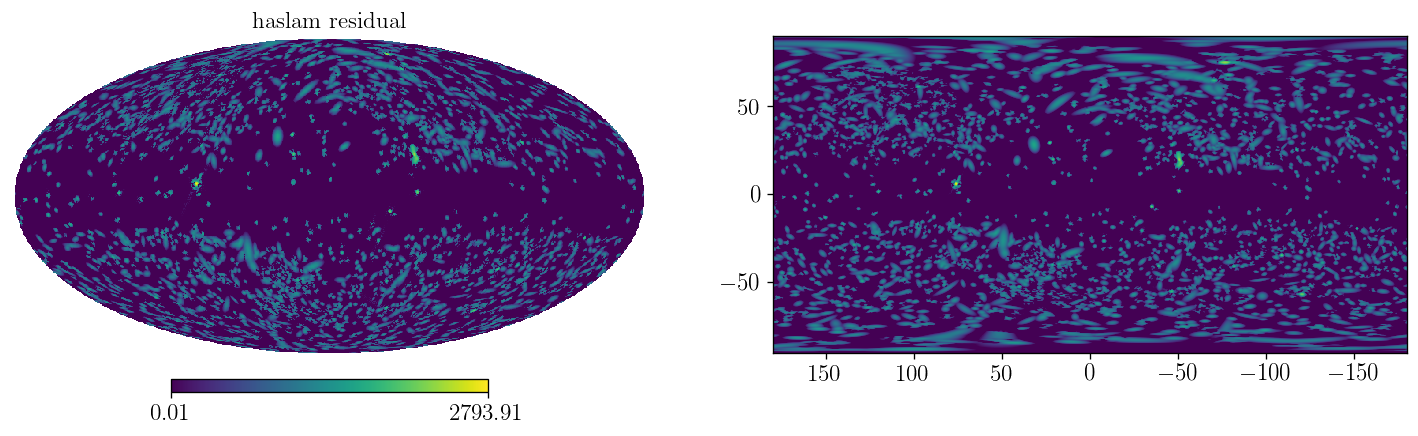

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plt.axes(axs[0])
hp.mollview(haslam_src_map_hp, hold=True, norm='log', min=1e-2, title='haslam residual')

axs[1].imshow(np.flip(np.log10(haslam_src_map)), vmin=-2, extent=(180, -180, -90, 90))

In [7]:
np.mean(haslam_src_map_hp)

0.388962

## 2. Keuhr catalog

In [5]:
egrs_list = egrs_list_keuhr()
print(len(egrs_list))

518


### 2.1 Spectra

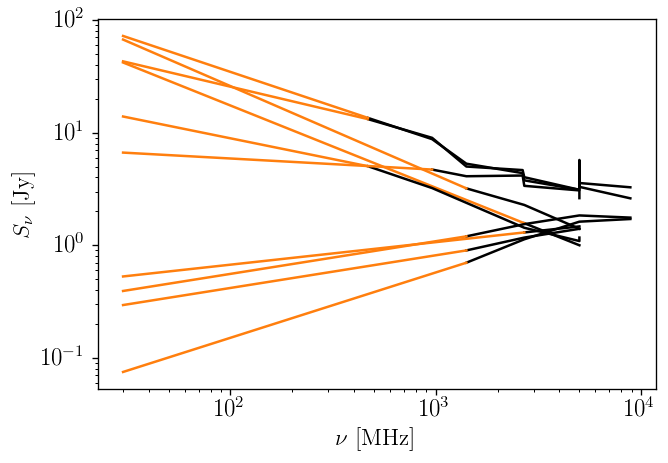

In [9]:
fig, ax = plt.subplots()

for egrs in egrs_list[:10]:
    egrs.plot_spec(ax)

ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$\nu$ [MHz]', ylabel=r'$S_\nu$ [Jy]');

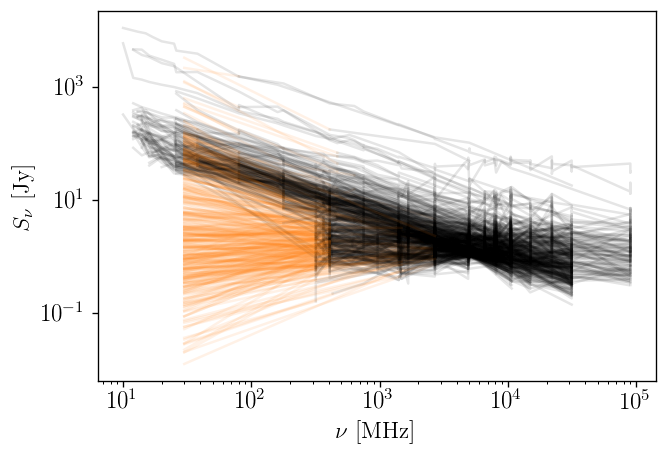

In [10]:
fig, ax = plt.subplots()

for egrs in egrs_list:
    egrs.plot_spec(ax, alpha=0.1)

ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$\nu$ [MHz]', ylabel=r'$S_\nu$ [Jy]');

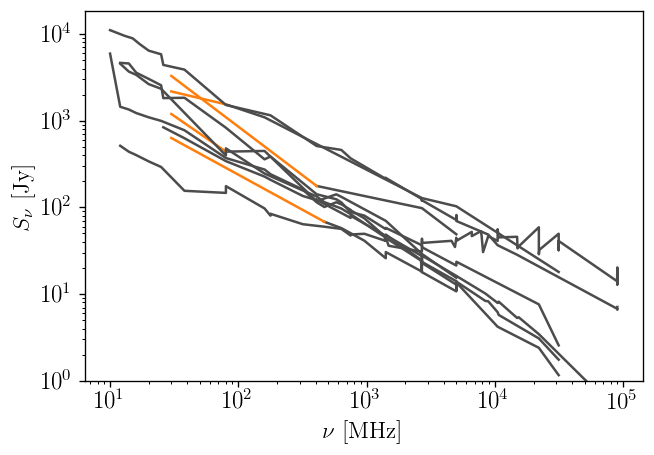

In [6]:
ind_best = np.argsort([egrs.Snu(1000) for egrs in egrs_list])[::-1]

fig, ax = plt.subplots()

for i in ind_best[:10]:
    egrs_list[i].plot_spec(ax, interp_color=cms['binary'](0.7), alpha=1)

ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e0, None))
ax.set(xlabel=r'$\nu$ [MHz]', ylabel=r'$S_\nu$ [Jy]')
fig.savefig('egrs_top_spec.pdf');

### 2.2 Making a map

In [12]:
src_map = np.zeros_like(b_grid)
prev_name = ''

for egrs in egrs_list:
        
    pixel_area = pixel_size ** 2 * np.cos(egrs.b) # [rad^2]
    I = egrs.Snu(nu_haslam)/pixel_area # [Jy sr^-1]
    # I = 2 * nu^2 kb T / c0^2
    # [MHz^2 g sr^-1] = [MHz^2] [cm^2 MHz^2 g] [cm^-2 MHz^-2]
    T = I * uc.Jy / (2 * nu_haslam**2 * uc.kb / uc.c0**2)

    i_b = np.searchsorted(b_edges[:-1], egrs.b) - 1
    i_l = np.searchsorted(l_edges[:-1], egrs.l_0center) - 1
    if T > 1e5:
        print('?')
    src_map[i_b, i_l] += T

In [13]:
n_sigma = 5
kernel_size = np.deg2rad(0.5) # [rad]
n_pix = int(np.round(2*n_sigma*kernel_size/pixel_size)) - 1
kernel = np.zeros((n_pix, n_pix))
i_c = (n_pix-1) / 2
for i in range(n_pix):
    for j in range(n_pix):
        kernel[i, j] = np.exp(- ((i-i_c)**2+(j-i_c)**2) / (2 * (kernel_size/pixel_size)**2))
kernel /= np.sum(kernel)
src_map_smoothed = convolve2d(src_map, kernel, mode='same')

In [14]:
np.mean(src_map), np.mean(src_map_smoothed)

(0.11004086075261987, 0.10972861508686176)

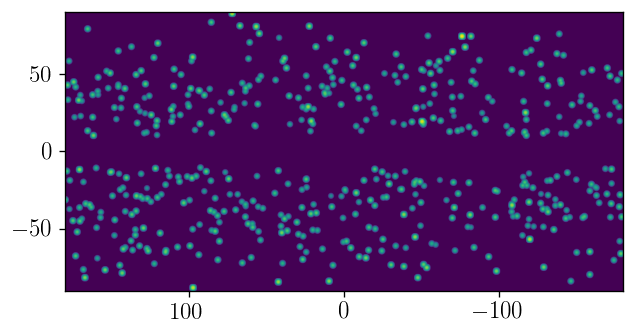

In [15]:
plt.imshow(np.flip(np.log10(np.clip(src_map_smoothed, 1e-5, None))), extent=(180, -180, -90, 90))